# 2021 Stack Overflow Survey Results analysis

[Data Exploration](##-data-exploration)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


## Data Exploration

In [2]:
# read data to dataframe
df_2021 = pd.read_csv('./survey_results_public.csv', encoding = "utf-8")
df_2021_schema = pd.read_csv('./survey_results_schema.csv', encoding = "utf-8")


First, we want to look at our data and understand the shape of it, the list of columns,
and look at some values.

In [3]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83439 entries, 0 to 83438
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ResponseId                    83439 non-null  int64  
 1   MainBranch                    83439 non-null  object 
 2   Employment                    83323 non-null  object 
 3   Country                       83439 non-null  object 
 4   US_State                      14920 non-null  object 
 5   UK_Country                    4418 non-null   object 
 6   EdLevel                       83126 non-null  object 
 7   Age1stCode                    83243 non-null  object 
 8   LearnCode                     82963 non-null  object 
 9   YearsCode                     81641 non-null  object 
 10  YearsCodePro                  61216 non-null  object 
 11  DevType                       66484 non-null  object 
 12  OrgSize                       60726 non-null  object 
 13  C

This dataset has 83439 entries and 48 columns. Only 3 columns are numerical.

In [4]:
df_2021.describe()

,ResponseId,CompTotal,ConvertedCompYearly
count,83439.000000,4.718300e+04,4.684400e+04
mean,41720.000000,2.119407e+69,1.184262e+05
std,24086.908893,4.603702e+71,5.272944e+05
min,1.000000,0.000000e+00,1.000000e+00
25%,20860.500000,1.600000e+04,2.702500e+04
50%,41720.000000,6.700000e+04,5.621100e+04
75%,62579.500000,1.400000e+05,1.000000e+05
max,83439.000000,1.000000e+74,4.524131e+07


Some values in CompTotal column are extremely large. We may have to deal with them later.

## Question 1: What programming languages were used the most among all respondents and in different countries?

Let's look at the values in the column **LanguageHaveWorkedWith**, containing used languages.

In [5]:
df_2021['LanguageHaveWorkedWith'].value_counts()

Python                                                                     1337
HTML/CSS;JavaScript;Node.js;TypeScript                                      811
Java                                                                        715
HTML/CSS;JavaScript;PHP;SQL                                                 674
C#                                                                          597
                                                                           ... 
Bash/Shell;C;C++;Haskell;HTML/CSS;Julia;Node.js;Perl;Python;R;Rust            1
HTML/CSS;Java;JavaScript;Kotlin;Node.js;PowerShell;Scala;SQL;TypeScript       1
C;C++;Dart;HTML/CSS;Java;JavaScript;Kotlin;PHP;PowerShell;Python;SQL          1
Bash/Shell;C;C++;HTML/CSS;JavaScript;Python;Rust;TypeScript                   1
C;C++;Go;Node.js                                                              1
Name: LanguageHaveWorkedWith, Length: 28690, dtype: int64

We can see, that it was a multiple choice question, and all the values are stored together, separated by semicolon.  
In order to analyze this data, we will need to count single languages.  

The following functions will help to split the values in the column, calculate proportions, and plot the results.

In [6]:
from collections import defaultdict


def get_possible_vals(col):
    '''
    INPUT 
        col - pandas Series, the column with semicolon separated values
    OUTPUT
        Set of single values in the column
    '''

    return(set([val.strip() for sublist in col.dropna().str.split(";").tolist() for val in sublist]))


def get_total_counts(df, col, col_suffix=''):
    '''
    INPUT 
        df - DataFrame, data
        col - string, holding the column name
        col_suffix - string, suffix for the 'count' column in the resulting dataframe
    OUTPUT
        new_df - DataFrame, value counts
    '''

    df_val_counts = df[col].value_counts().reset_index()
    df_val_counts = df_val_counts.rename(columns={'index': 'value', col: 'count'})
    possible_vals = get_possible_vals(df[col])

    new_df = defaultdict(int)
    #loop through the list of possible values
    for val in possible_vals:
        #loop through rows
        for idx in range(df_val_counts.shape[0]):
            row_vals = df_val_counts['value'][idx].split(";")
            if val in row_vals:
                new_df[val] += int(df_val_counts['count'][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = ['value', 'count'+col_suffix]
    return new_df


def clean_and_plot(df, col, col_suffix='', title='', plot=True):
    '''
    INPUT 
        df - DataFrame, data
        col - string, holding the column name
        col_suffix - string, suffix for the 'count' column in the resulting dataframe
        title - string, the title of plot
        plot - bool, whether or not a plot needed
    OUTPUT
        df_prop - DataFrame, proportions of the column values
        Displays a plot for proportions of the column values.
    '''

    df_counts = get_total_counts(df, col, col_suffix)

    df_prop = df_counts.sort_values('count'+col_suffix, ascending=True).set_index('value')
    df_prop = df_prop/df[col].shape[0]
    if plot:
        df_prop.plot(kind='barh',figsize=(10,0.25*len(df_prop)), legend=None, ylabel='Y').grid(axis='x');
        plt.ylabel('')
        plt.title(title+', proportion')
        plt.show()
    return df_prop


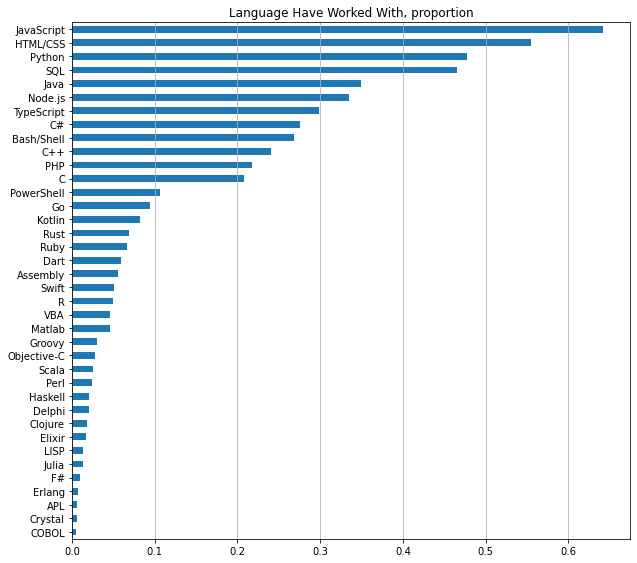

In [7]:
df_lang_worked = clean_and_plot(df_2021, col='LanguageHaveWorkedWith', title='Language Have Worked With')


We can see,that JavaScript, HTML/CSS, Python and SQL were used the most. JavaScript is the clear leader.
On the other hand COBOL, Crystal, APL, Erlang are rarely used.

I want to create a wordcloud with this data and use it in my blog.

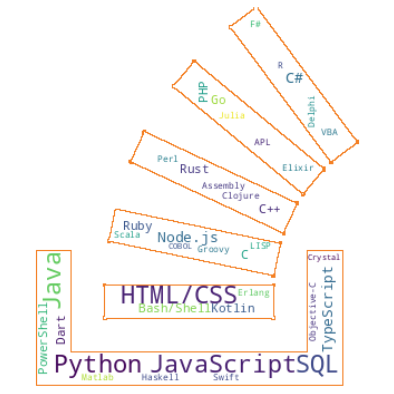

In [8]:
# Some of the code used from https://amueller.github.io/word_cloud/auto_examples/parrot.html

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import numpy as np
from scipy.ndimage import gaussian_gradient_magnitude

df_lang = df_lang_worked.copy().reset_index()
df_lang['count'] = (df_lang['count'] * 10000).astype(int)

tuples = [tuple(x) for x in df_lang.values]
so_color = np.array(Image.open('so_logo2.png'))
# subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
so_color = so_color[::3, ::3]

# create mask  white is "masked out"
so_mask = so_color.copy()
so_mask[so_mask.sum(axis=2) == 0] = 255

# some finesse: we enforce boundaries between colors so they get less washed out.
# For that we do some edge detection in the image
edges = np.mean([gaussian_gradient_magnitude(so_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
so_mask[edges > .08] = 255

image_colors = ImageColorGenerator(so_color)
#wordcloud = WordCloud(background_color="#302d2b", mask=so_mask, contour_width=3, contour_color='firebrick').generate_from_frequencies(dict(tuples))
wordcloud = WordCloud(background_color="white", mask=so_mask, contour_width=1, contour_color='#f48024',
                    random_state=42, relative_scaling=0).generate_from_frequencies(dict(tuples))
plt.figure(figsize=[10,7])
#plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud.to_file("wordcloud.png");

I am curious if distribution of languages is different by countries.  

First, let's see what countries do respondents represent.

In [9]:
df_2021['Country'].value_counts()

United States of America                                15288
India                                                   10511
Germany                                                  5625
United Kingdom of Great Britain and Northern Ireland     4475
Canada                                                   3012
                                                        ...  
Brunei Darussalam                                           1
Tuvalu                                                      1
Saint Kitts and Nevis                                       1
Saint Vincent and the Grenadines                            1
Dominica                                                    1
Name: Country, Length: 181, dtype: int64

I want to compare top 5 countries from that list plus 2 other big countries: Russia and China.

In [10]:
df_us = df_2021[df_2021['Country']=='United States of America']
df_in = df_2021[df_2021['Country']=='India']
df_ge = df_2021[df_2021['Country']=='Germany']
df_uk = df_2021[df_2021['Country']=='United Kingdom of Great Britain and Northern Ireland']
df_ca = df_2021[df_2021['Country']=='Canada']
df_ru = df_2021[df_2021['Country']=='Russian Federation']
df_ch = df_2021[df_2021['Country']=='China']


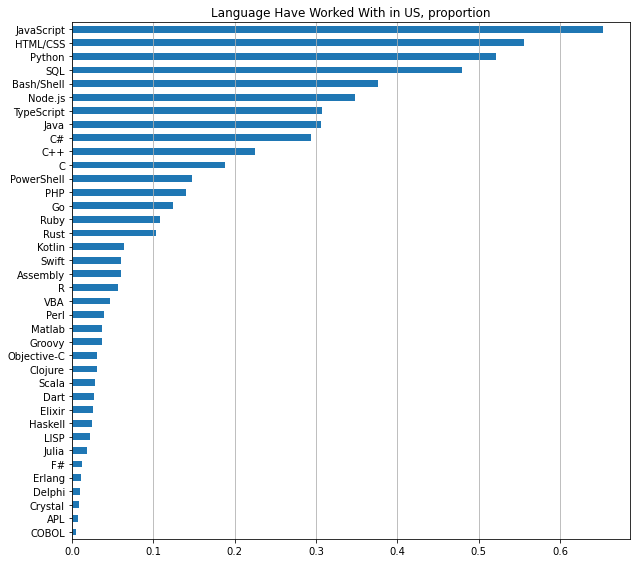

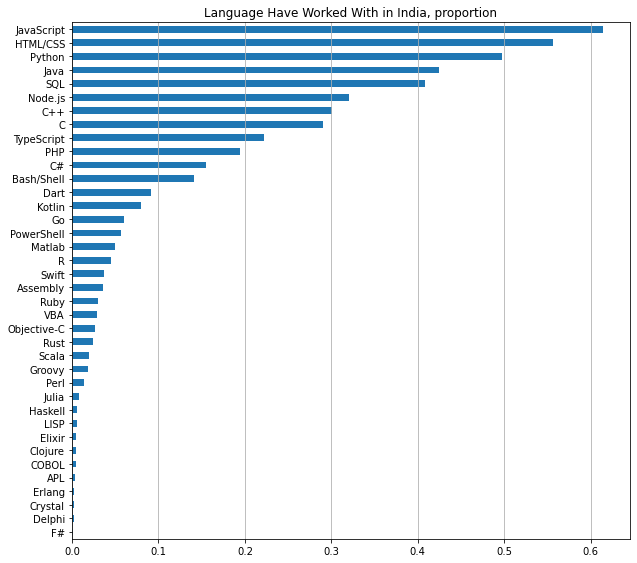

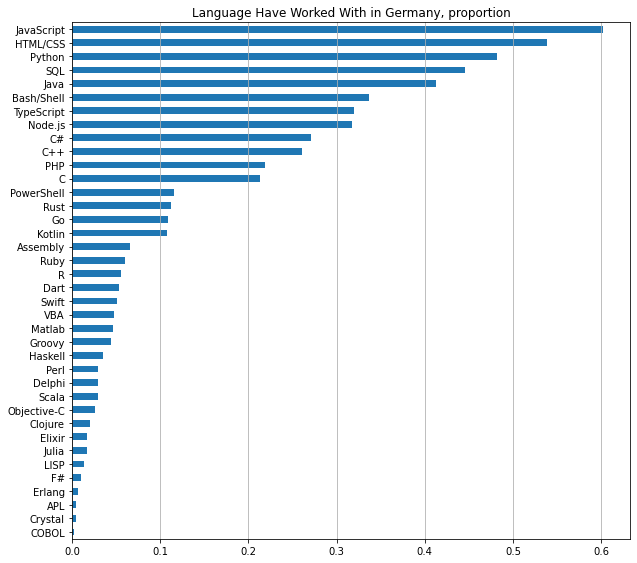

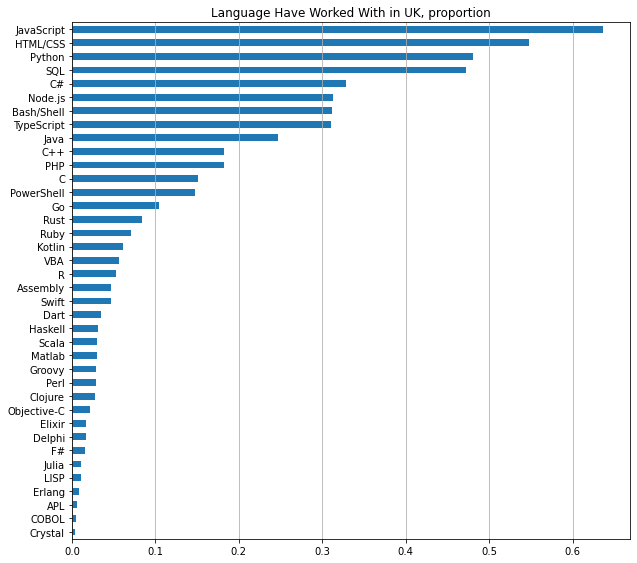

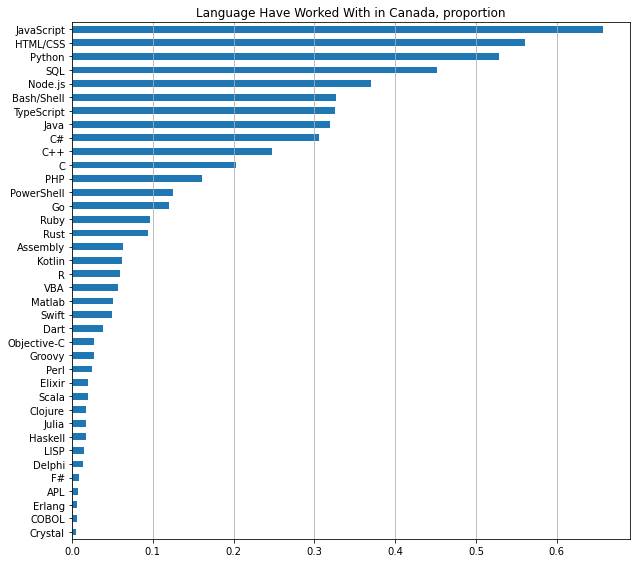

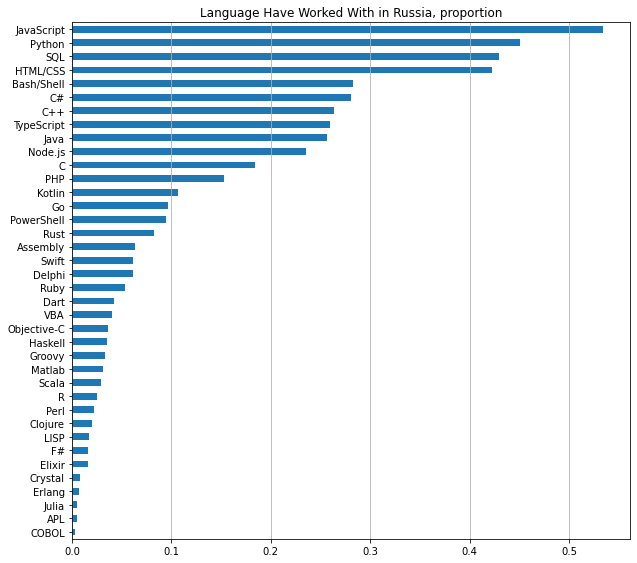

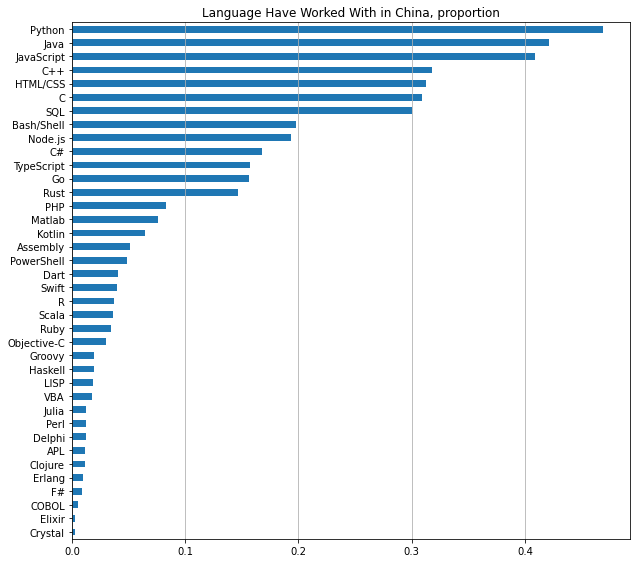

In [11]:
df_lang_worked_us = clean_and_plot(df_us, col='LanguageHaveWorkedWith', col_suffix='_us', title='Language Have Worked With in US')
df_lang_worked_in = clean_and_plot(df_in, col='LanguageHaveWorkedWith', col_suffix='_in', title='Language Have Worked With in India')
df_lang_worked_ge = clean_and_plot(df_ge, col='LanguageHaveWorkedWith', col_suffix='_ge', title='Language Have Worked With in Germany')
df_lang_worked_uk = clean_and_plot(df_uk, col='LanguageHaveWorkedWith', col_suffix='_uk', title='Language Have Worked With in UK')
df_lang_worked_ca = clean_and_plot(df_ca, col='LanguageHaveWorkedWith', col_suffix='_ca', title='Language Have Worked With in Canada')
df_lang_worked_ru = clean_and_plot(df_ru, col='LanguageHaveWorkedWith', col_suffix='_ru', title='Language Have Worked With in Russia')
df_lang_worked_ch = clean_and_plot(df_ch, col='LanguageHaveWorkedWith', col_suffix='_ch', title='Language Have Worked With in China')


Looking at these plots we can see that China has different distribution. JavaScript there is only 3rd. Python and Java are at the top. Also, C++ is getting ahead of HTML/CSS, and SQL is only 7th.  

I would like to see the distribution of languages by country on one plot, to be able to better compare proportions.  

First, let's combine data in one DataFrame.

In [12]:
df_lang_worked_joined = df_lang_worked_us.join(
    df_lang_worked_in).join(
    df_lang_worked_ge).join(
    df_lang_worked_uk).join(
    df_lang_worked_ca).join(
    df_lang_worked_ru).join(
    df_lang_worked_ch)
df_lang_worked_joined = df_lang_worked_joined.rename(columns={'count_us':'USA','count_in':'India','count_ge':'Germany','count_uk':'UK','count_ca':'Canada','count_ru':'Russia','count_ch':'China'})
df_lang_worked_joined = df_lang_worked_joined.sort_values(by=['USA'], ascending=False)
df_lang_worked_joined

,USA,India,Germany,UK,Canada,Russia,China
value,,,,,,,
JavaScript,0.653257,0.614594,0.602489,0.636872,0.657703,0.534600,0.408531
HTML/CSS,0.555468,0.555989,0.538667,0.547486,0.561089,0.422659,0.312796
Python,0.521651,0.497859,0.482311,0.480223,0.528884,0.451153,0.469194
SQL,0.479592,0.408049,0.445333,0.471732,0.451527,0.429444,0.300474
Bash/Shell,0.376570,0.141090,0.336889,0.311955,0.327357,0.282904,0.198104
Node.js,0.348051,0.320902,0.317689,0.312626,0.370186,0.235414,0.193365
TypeScript,0.307496,0.222529,0.319644,0.309944,0.325697,0.259159,0.157346
Java,0.306646,0.424222,0.412267,0.247374,0.319721,0.256445,0.420853
C#,0.294152,0.155266,0.271467,0.328939,0.305445,0.280868,0.167773


In [13]:
def line_plot(df,title=''):
    '''
    INPUT 
        df - DataFrame, data
        title - string, the title of plot
    OUTPUT
        Displays a line plot for proportions of the column values.

    '''
    df.plot(kind='line',figsize=(15,8),rot=75,colormap='tab10').grid(axis='x');
    plt.xticks(np.arange(len(df.index)), df.index);
    plt.xlabel('')
    plt.title(title+', proportion')
    plt.show()


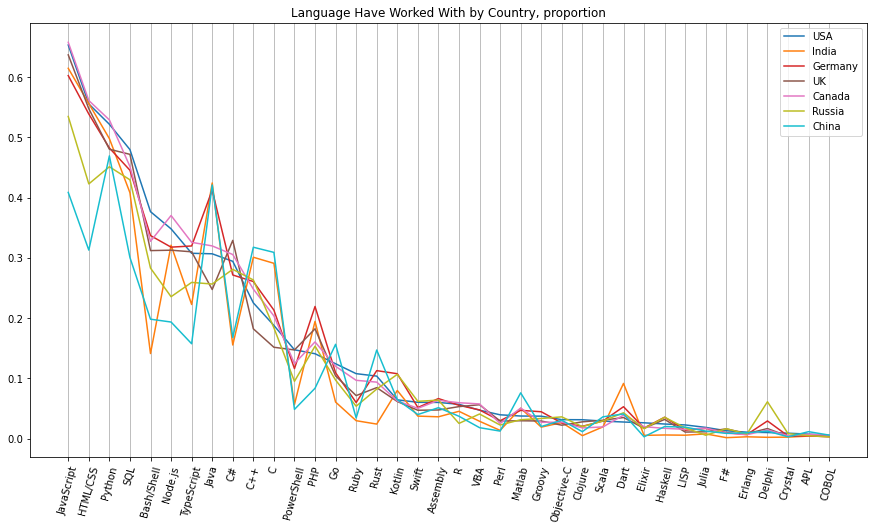

In [14]:
line_plot(df_lang_worked_joined, 'Language Have Worked With by Country')

This plot reveals us very interesting insights.  
Compared to other countries:
- Python is more popular than HTML/CSS in Russia and China.
- India has a noticeable low use of Bash/Shell, Go, Rust.
- At the same time, Dart is very popular in India.
- Old Delphi is still widely used in Russia.
- Only in the USA PHP is less popular than PowerShell.
- Java is very popular in India, Germany and China.


## Question 2: What operating systems were used the most among all respondents and in different countries?

Let's check the values in the column **OpSys**.

In [15]:
df_2021['OpSys'].value_counts()

Windows                              37758
Linux-based                          21088
MacOS                                20984
Windows Subsystem for Linux (WSL)     2743
Other (please specify):                575
BSD                                    146
Name: OpSys, dtype: int64

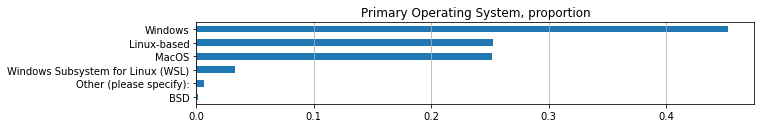

In [16]:
df_OpSys = clean_and_plot(df_2021, col='OpSys', title='Primary Operating System')


Windows is by far the leading operating system. Next, Linux-based and MacOS are used by about the same amount of respondents.  

Let's look how the plots look like by country.

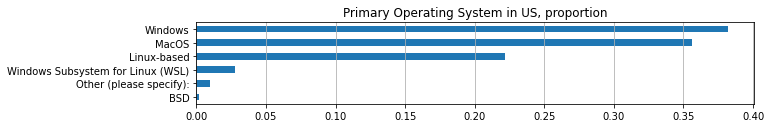

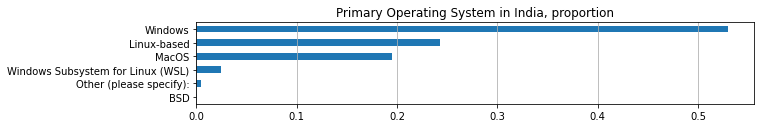

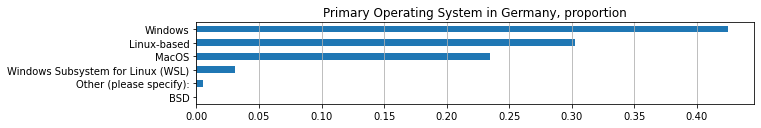

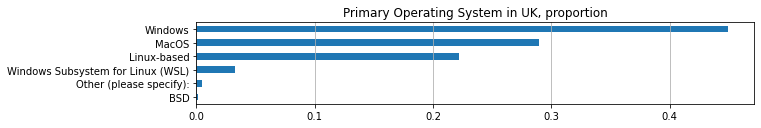

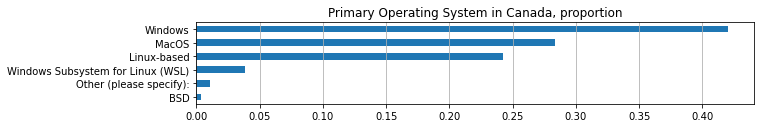

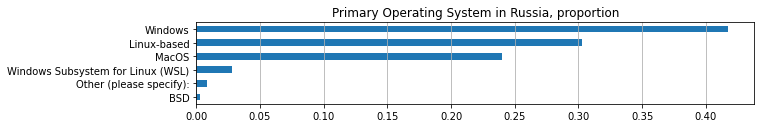

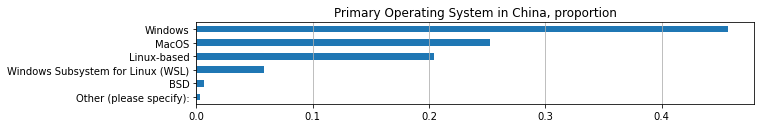

In [17]:
df_OpSys_us = clean_and_plot(df_us, col='OpSys', col_suffix='_us', title='Primary Operating System in US')
df_OpSys_in = clean_and_plot(df_in, col='OpSys', col_suffix='_in', title='Primary Operating System in India')
df_OpSys_ge = clean_and_plot(df_ge, col='OpSys', col_suffix='_ge', title='Primary Operating System in Germany')
df_OpSys_uk = clean_and_plot(df_uk, col='OpSys', col_suffix='_uk', title='Primary Operating System in UK')
df_OpSys_ca = clean_and_plot(df_ca, col='OpSys', col_suffix='_ca', title='Primary Operating System in Canada')
df_OpSys_ru = clean_and_plot(df_ru, col='OpSys', col_suffix='_ru', title='Primary Operating System in Russia')
df_OpSys_ch = clean_and_plot(df_ch, col='OpSys', col_suffix='_ch', title='Primary Operating System in China')


MacOS is actually very close to Windows in the USA.

Again, I would like to compare proportions by country.

In [18]:
# combine DataFrames by country in one
df_OpSys_joined = df_OpSys_us.join(
    df_OpSys_in).join(
    df_OpSys_ge).join(
    df_OpSys_uk).join(
    df_OpSys_ca).join(
    df_OpSys_ru).join(
    df_OpSys_ch)
df_OpSys_joined = df_OpSys_joined.rename(columns={'count_us':'USA','count_in':'India','count_ge':'Germany','count_uk':'UK','count_ca':'Canada','count_ru':'Russia','count_ch':'China'})
df_OpSys_joined = df_OpSys_joined.sort_values(by=['USA'], ascending=False)
df_OpSys_joined

,USA,India,Germany,UK,Canada,Russia,China
value,,,,,,,
Windows,0.381803,0.529731,0.424533,0.449162,0.419987,0.417232,0.456872
MacOS,0.355965,0.194558,0.234667,0.289385,0.283201,0.240163,0.252133
Linux-based,0.221415,0.242984,0.302756,0.221676,0.242364,0.302578,0.204739
Windows Subsystem for Linux (WSL),0.027669,0.024165,0.031289,0.032626,0.038845,0.027815,0.057820
Other (please specify):,0.009746,0.005042,0.005689,0.005140,0.010624,0.008141,0.002844
BSD,0.001832,0.000951,0.000711,0.001117,0.003652,0.002714,0.006635


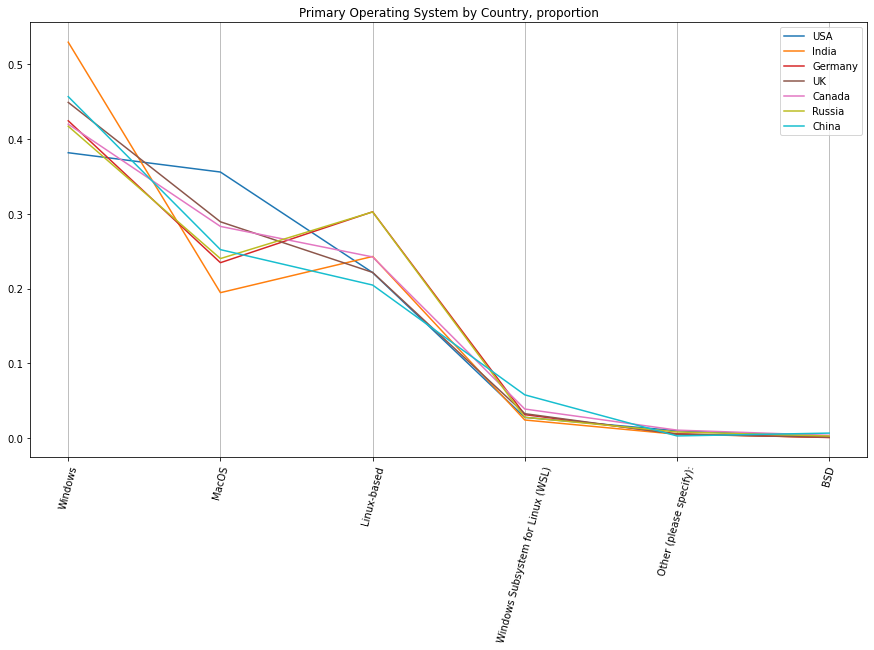

In [19]:
line_plot(df_OpSys_joined, 'Primary Operating System by Country')

Here we also got some interesting results.  
Compared to other countries:
- US has the smallest proportion of Windows users and the biggest proportion of MacOS users.
- As opposed to US India has the biggest proportion of Windows users and the smallest proportion of MacOS users.
- Russia and Germany have almost identical distributions.
- Linux-based OS is more popular than MacOS only in Russia, Germany and India.


## Question 3: What is the highest level of education among all respondents and in different countries?

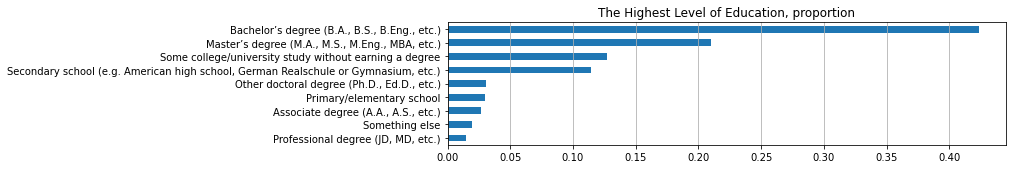

In [20]:
df_EdLevel = clean_and_plot(df_2021, col='EdLevel', title='The Highest Level of Education')


Looks like almost half of respondents have Bachelor's degree. Next big group, just a little over 20%, have Master's degree.

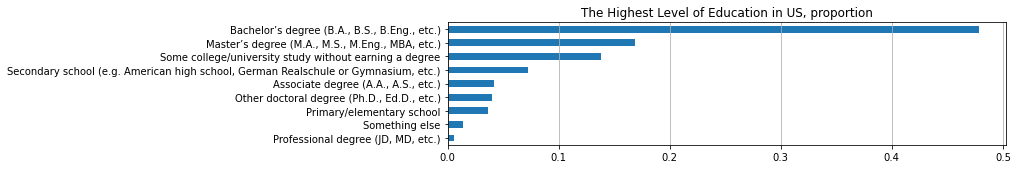

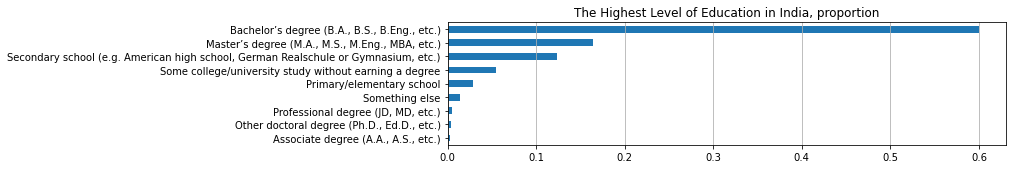

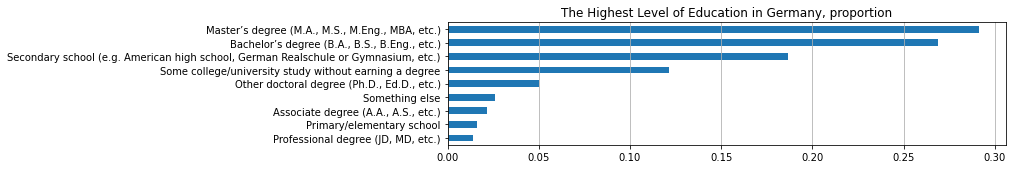

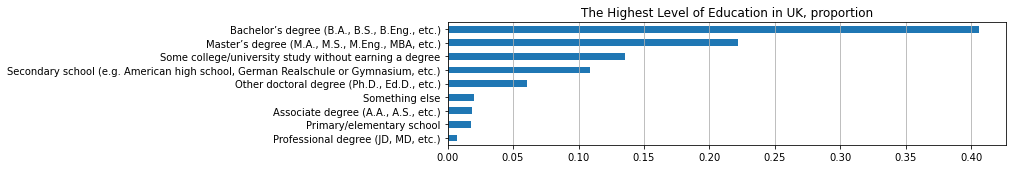

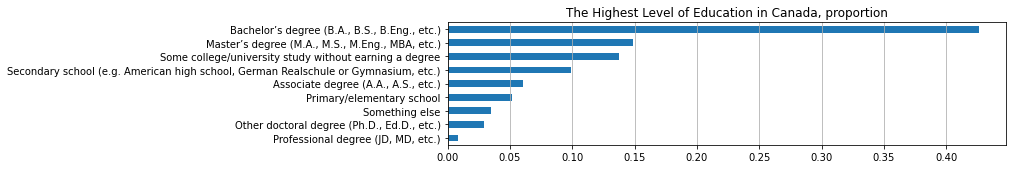

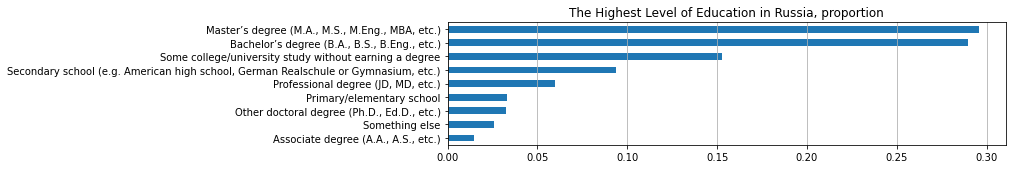

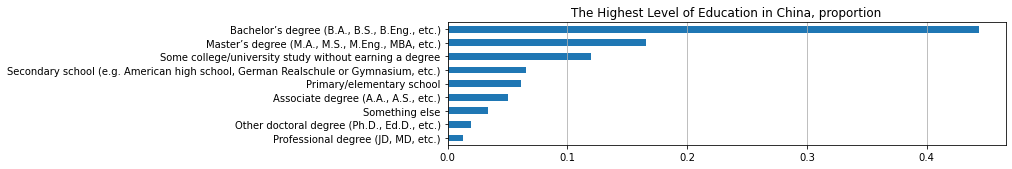

In [21]:
df_EdLevel_us = clean_and_plot(df_us, col='EdLevel', col_suffix='_us', title='The Highest Level of Education in US')
df_EdLevel_in = clean_and_plot(df_in, col='EdLevel', col_suffix='_in', title='The Highest Level of Education in India')
df_EdLevel_ge = clean_and_plot(df_ge, col='EdLevel', col_suffix='_ge', title='The Highest Level of Education in Germany')
df_EdLevel_uk = clean_and_plot(df_uk, col='EdLevel', col_suffix='_uk', title='The Highest Level of Education in UK')
df_EdLevel_ca = clean_and_plot(df_ca, col='EdLevel', col_suffix='_ca', title='The Highest Level of Education in Canada')
df_EdLevel_ru = clean_and_plot(df_ru, col='EdLevel', col_suffix='_ru', title='The Highest Level of Education in Russia')
df_EdLevel_ch = clean_and_plot(df_ch, col='EdLevel', col_suffix='_ch', title='The Highest Level of Education in China')


We can see that in Germany and Russia the most responders have Master's degree, in other countries - Bachelor's degree.

Again, let's look at the distribution by country on one plot.

In [22]:
df_EdLevel_joined = df_EdLevel_us.join(
    df_EdLevel_in).join(
    df_EdLevel_ge).join(
    df_EdLevel_uk).join(
    df_EdLevel_ca).join(
    df_EdLevel_ru).join(
    df_EdLevel_ch)
df_EdLevel_joined = df_EdLevel_joined.rename(columns={'count_us':'USA','count_in':'India','count_ge':'Germany','count_uk':'UK','count_ca':'Canada','count_ru':'Russia','count_ch':'China'})
df_EdLevel_joined = df_EdLevel_joined.sort_values(by=['USA'], ascending=False)
df_EdLevel_joined

,USA,India,Germany,UK,Canada,Russia,China
value,,,,,,,
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0.478480,0.600133,0.269156,0.405810,0.426295,0.289688,0.443602
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.168629,0.163828,0.291378,0.221676,0.149070,0.295794,0.165877
Some college/university study without earning a degree,0.137886,0.054895,0.121600,0.135866,0.137782,0.152646,0.119431
"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",0.072410,0.123585,0.186489,0.108380,0.098938,0.093623,0.065403
"Associate degree (A.A., A.S., etc.)",0.041732,0.002474,0.021867,0.018771,0.060425,0.014925,0.050237
"Other doctoral degree (Ph.D., Ed.D., etc.)",0.039704,0.003901,0.049956,0.060559,0.029548,0.032564,0.019905
Primary/elementary school,0.036041,0.028256,0.016178,0.018101,0.051461,0.033243,0.061611
Something else,0.014129,0.013605,0.025778,0.019888,0.034529,0.025780,0.034123
"Professional degree (JD, MD, etc.)",0.006214,0.005423,0.014044,0.007374,0.008300,0.059701,0.013270


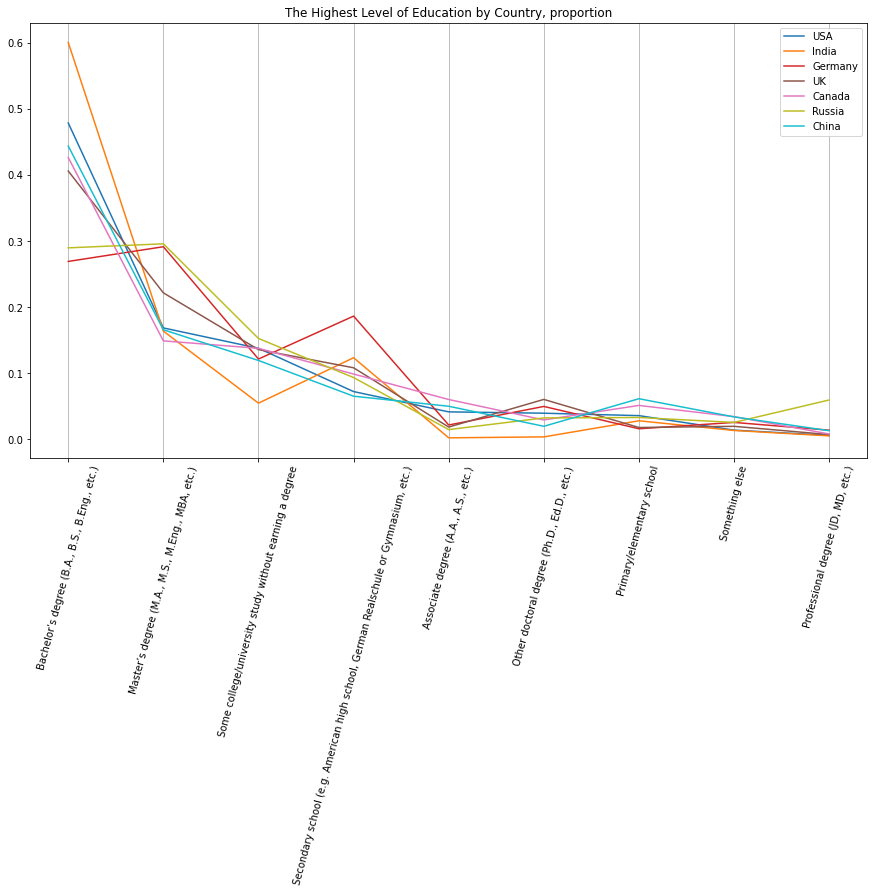

In [23]:
line_plot(df_EdLevel_joined, 'The Highest Level of Education by Country')

Compared to other countries:
- India has by far highest proportion of respondents with Bachelor's degree.
- Doctoral degree is more popular in UK.
- Germany and Russia have the highest proportion of respondents with Master's degree.

In [26]:
df_HighEdLevel_joined = df_EdLevel_joined.drop([
    'Some college/university study without earning a degree',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
    'Associate degree (A.A., A.S., etc.)',
    'Primary/elementary school',
    'Something else',
    'Professional degree (JD, MD, etc.)'
], axis=0)
df_HighEdLevel_joined

,USA,India,Germany,UK,Canada,Russia,China
value,,,,,,,
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0.478480,0.600133,0.269156,0.405810,0.426295,0.289688,0.443602
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.168629,0.163828,0.291378,0.221676,0.149070,0.295794,0.165877
"Other doctoral degree (Ph.D., Ed.D., etc.)",0.039704,0.003901,0.049956,0.060559,0.029548,0.032564,0.019905


In [34]:
df_HighEdLevel_transposed = df_HighEdLevel_joined.T
df_HighEdLevel_transposed['total'] = df_HighEdLevel_transposed.sum(axis=1)
df_HighEdLevel_transposed = df_HighEdLevel_transposed.sort_values(by=['total'], ascending=False)
df_HighEdLevel_transposed

value,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Other doctoral degree (Ph.D., Ed.D., etc.)",total
India,0.600133,0.163828,0.003901,0.767862
UK,0.405810,0.221676,0.060559,0.688045
USA,0.478480,0.168629,0.039704,0.686813
China,0.443602,0.165877,0.019905,0.629384
Russia,0.289688,0.295794,0.032564,0.618046
Germany,0.269156,0.291378,0.049956,0.610489
Canada,0.426295,0.149070,0.029548,0.604914


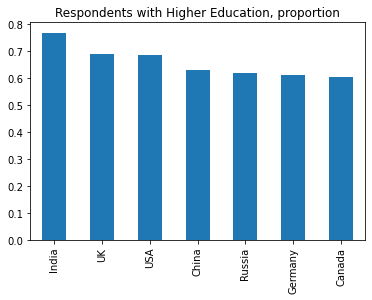

In [37]:
df_HighEdLevel_transposed.plot.bar(y='total', title='Respondents with Higher Education, proportion', legend=None);

## Question 4: How well can we predict the SO Visit Frequency?

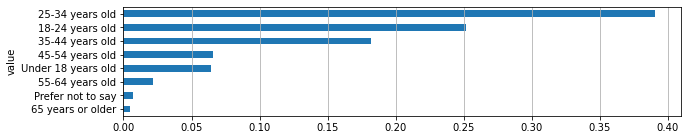

In [19]:
df_Age = clean_and_plot(df_2021, col='Age')

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


### Clean the data

In [21]:
df_2021.shape

(83439, 48)

In [22]:
def missing_vals(df):
    missing = {}
    for col in df.columns:
        prop_miss = round(df[col].isna().mean(),4)
        missing[col] = prop_miss
        print(f'{col}: {prop_miss}')
    return missing

In [23]:
missing_dict = missing_vals(df_2021);

ResponseId: 0.0
MainBranch: 0.0
Employment: 0.0014
Country: 0.0
US_State: 0.8212
UK_Country: 0.9471
EdLevel: 0.0038
Age1stCode: 0.0023
LearnCode: 0.0057
YearsCode: 0.0215
YearsCodePro: 0.2663
DevType: 0.2032
OrgSize: 0.2722
Currency: 0.268
CompTotal: 0.4345
CompFreq: 0.375
LanguageHaveWorkedWith: 0.013
LanguageWantToWorkWith: 0.0793
DatabaseHaveWorkedWith: 0.1665
DatabaseWantToWorkWith: 0.3013
PlatformHaveWorkedWith: 0.3752
PlatformWantToWorkWith: 0.5012
WebframeHaveWorkedWith: 0.2605
WebframeWantToWorkWith: 0.3757
MiscTechHaveWorkedWith: 0.4361
MiscTechWantToWorkWith: 0.5443
ToolsTechHaveWorkedWith: 0.1307
ToolsTechWantToWorkWith: 0.2152
NEWCollabToolsHaveWorkedWith: 0.0264
NEWCollabToolsWantToWorkWith: 0.1248
OpSys: 0.0017
NEWStuck: 0.0046
NEWSOSites: 0.0032
SOVisitFreq: 0.0123
SOAccount: 0.011
SOPartFreq: 0.1904
SOComm: 0.0134
NEWOtherComms: 0.0073
Age: 0.0124
Gender: 0.0138
Trans: 0.0331
Sexuality: 0.1207
Ethnicity: 0.0476
Accessibility: 0.0699
MentalHealth: 0.0781
SurveyLength: 0.

In [24]:
drop_target_na = df_2021.dropna(subset=['Age']) # drop rows with na in response variable (Age)
drop_target_na.shape

(82407, 48)

In [25]:
# split on numeric and categorical

# List of categorical columns
cat_cols = [col for col in drop_target_na.columns if drop_target_na[col].dtype == "object"]
# List of numerical columns
num_cols = [col for col in drop_target_na.columns if drop_target_na[col].dtype != "object"]

print(f'categorical: {len(cat_cols)}\nnumerical: {len(num_cols)}')

categorical: 45
numerical: 3


#### Clean numerical data

In [26]:
missing_vals(drop_target_na[num_cols]);

ResponseId: 0.0
CompTotal: 0.4288
ConvertedCompYearly: 0.4329


In [27]:
fill_mean = lambda col: col.fillna(col.median()) if (col.name in num_cols) else col 

fill_num_na = drop_target_na.apply(fill_mean, axis=0) #Fill all missing values with the mean of the column.
missing_vals(fill_num_na[num_cols]);

ResponseId: 0.0
CompTotal: 0.0
ConvertedCompYearly: 0.0


In [28]:
fill_num_na[fill_num_na['CompTotal']>10**18][num_cols]

,ResponseId,CompTotal,ConvertedCompYearly
103,104,1.000000e+29,56211.0
6378,6379,1.000000e+74,56211.0
18919,18920,8.000000e+52,56211.0
62417,62418,7.000000e+39,56211.0


In [29]:
print(fill_num_na.shape)
fill_num_na = fill_num_na.drop(fill_num_na[fill_num_na['CompTotal']>10**18].index)
print(fill_num_na.shape)


(82407, 48)
(82403, 48)


#### Clean categorical data

In [30]:
cat_cols2 = cat_cols.copy()
cat_cols2.remove('Age')

#num_df = fill_num_na.drop(cat_cols2, axis=1)
cat_cols2

['MainBranch',
 'Employment',
 'Country',
 'US_State',
 'UK_Country',
 'EdLevel',
 'Age1stCode',
 'LearnCode',
 'YearsCode',
 'YearsCodePro',
 'DevType',
 'OrgSize',
 'Currency',
 'CompFreq',
 'LanguageHaveWorkedWith',
 'LanguageWantToWorkWith',
 'DatabaseHaveWorkedWith',
 'DatabaseWantToWorkWith',
 'PlatformHaveWorkedWith',
 'PlatformWantToWorkWith',
 'WebframeHaveWorkedWith',
 'WebframeWantToWorkWith',
 'MiscTechHaveWorkedWith',
 'MiscTechWantToWorkWith',
 'ToolsTechHaveWorkedWith',
 'ToolsTechWantToWorkWith',
 'NEWCollabToolsHaveWorkedWith',
 'NEWCollabToolsWantToWorkWith',
 'OpSys',
 'NEWStuck',
 'NEWSOSites',
 'SOVisitFreq',
 'SOAccount',
 'SOPartFreq',
 'SOComm',
 'NEWOtherComms',
 'Gender',
 'Trans',
 'Sexuality',
 'Ethnicity',
 'Accessibility',
 'MentalHealth',
 'SurveyLength',
 'SurveyEase']

In [31]:
fill_num_na[(fill_num_na['Country']!='United States of America') & fill_num_na['US_State'].notna()]

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly


In [32]:
fill_num_na.loc[fill_num_na['Country']=='United States of America', 'Country'] = 'US/'+fill_num_na['US_State']
fill_num_na = fill_num_na.drop('US_State', axis=1)
cat_cols2.remove('US_State')
fill_num_na.shape

(82403, 47)

In [33]:
fill_num_na[(fill_num_na['Country']!='United Kingdom of Great Britain and Northern Ireland') & fill_num_na['UK_Country'].notna()]

,ResponseId,MainBranch,Employment,Country,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,YearsCodePro,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly


In [34]:
fill_num_na.loc[fill_num_na['Country']=='United Kingdom of Great Britain and Northern Ireland', 'Country'] = 'UK/'+fill_num_na['UK_Country']
fill_num_na = fill_num_na.drop('UK_Country', axis=1)
cat_cols2.remove('UK_Country')
fill_num_na.shape

(82403, 46)

In [35]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue

    return df

In [36]:
dont_use = ['LearnCode','DevType',
            'LanguageHaveWorkedWith','LanguageWantToWorkWith',
            'DatabaseHaveWorkedWith','DatabaseWantToWorkWith',
            'PlatformHaveWorkedWith','PlatformWantToWorkWith',
            'WebframeHaveWorkedWith','WebframeWantToWorkWith',
            'MiscTechHaveWorkedWith','MiscTechWantToWorkWith',
            'ToolsTechHaveWorkedWith','ToolsTechWantToWorkWith',
            'NEWCollabToolsHaveWorkedWith','NEWCollabToolsWantToWorkWith',
            'NEWStuck','NEWSOSites', 'Ethnicity', 'Accessibility', 'Sexuality', 'Gender', 'MentalHealth']
cat_features = list(set(cat_cols2)-set(dont_use))
num_cat_df = fill_num_na.drop(dont_use, axis=1)
print(num_cat_df.shape)
print(num_cat_df.columns)

(82403, 23)
Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'EdLevel',
       'Age1stCode', 'YearsCode', 'YearsCodePro', 'OrgSize', 'Currency',
       'CompTotal', 'CompFreq', 'OpSys', 'SOVisitFreq', 'SOAccount',
       'SOPartFreq', 'SOComm', 'NEWOtherComms', 'Age', 'Trans', 'SurveyLength',
       'SurveyEase', 'ConvertedCompYearly'],
      dtype='object')


In [37]:
#Split into explanatory and response variables
X = num_cat_df.drop(['Age','ResponseId'], axis=1)
y = num_cat_df['Age']

X.shape

(82403, 21)

In [38]:
X = create_dummy_df(X, cat_features, dummy_na=True)


In [39]:
X.shape

(82403, 572)

In [40]:
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


In [41]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train, y_train)

cv = cross_val_score(rf,X_train,y_train,cv=5)
print(f'{cv} => mean = {cv.mean()}')


[0.72557857 0.72566525 0.73136269 0.73439667 0.73118932] => mean = 0.7296385013206621


**['ResponseId','CompTotal','ConvertedCompYearly']**
- [0.2658173  0.26315333 0.27303458 0.26852735 0.26835399] => mean = **0.26777731095953267**
- [0.30351881 0.30328508 0.30068475 0.30649216 0.3020716 ] => mean = **0.3032104790013449**

**['CompTotal','ConvertedCompYearly']**
- [0.2951118  0.30415186 0.29747768 0.29531074 0.29149692] => mean = **0.29670980130355423**
- [0.28141792 0.29635087 0.28369593 0.30718558 0.30666551] => mean = **0.29506316342336164**

**['MainBranch','CompTotal','ConvertedCompYearly']**
- [0.30169873 0.31307966 0.30640548 0.30926584 0.29834446] => mean = **0.3057588333408231**
- [0.2817646  0.3063188  0.28334922 0.30718558 0.30666551] => mean = **0.2970567432676793**

**['MainBranch','Employment','CompTotal','ConvertedCompYearly']**
- [0.29857861 0.30909249 0.3039785  0.30571206 0.30120482] => mean = **0.30371329498812843**
- [0.28150459 0.3063188  0.28326255 0.30675219 0.30666551] => mean = **0.296900728012594**

**['MainBranch','Employment','Country','CompTotal','ConvertedCompYearly']**
- [0.28427804 0.29193031 0.28742307 0.28794314 0.28568952] => mean = **0.28745281653743976**
- [0.28141792 0.29583081 0.28317587 0.30675219 0.30666551] => mean = **0.2947684594275222**

**+EdLevel**
- [0.27855781 0.28022883 0.28178903 0.27728179 0.27936205] => mean = **0.27944390122546625**
- [0.28141792 0.29583081 0.28317587 0.30675219 0.30666551] => mean = **0.2947684594275222**

**All except: ['LearnCode','DevType',
            'LanguageHaveWorkedWith','LanguageWantToWorkWith',
            'DatabaseHaveWorkedWith','DatabaseWantToWorkWith',
            'PlatformHaveWorkedWith','PlatformWantToWorkWith',
            'WebframeHaveWorkedWith','WebframeWantToWorkWith',
            'MiscTechHaveWorkedWith','MiscTechWantToWorkWith',
            'ToolsTechHaveWorkedWith','ToolsTechWantToWorkWith',
            'NEWCollabToolsHaveWorkedWith','NEWCollabToolsWantToWorkWith',
            'NEWStuck','NEWSOSites']**
- [0.35309412 0.35615845 0.34601716 0.35139118 0.35693855] => mean = **0.35271989088803385**
- [0.28150459 0.29799775 0.28317587 0.30675219 0.30666551] => mean = **0.29521918168339234**



- [0.71673745 0.71838433 0.72286755 0.72850208 0.72884882] => mean = **0.7230680457388681**

In [42]:
# Make predictions for the test set
y_pred_test = rf.predict(X_test)

In [43]:
from sklearn.metrics import accuracy_score

# View accuracy score
accuracy_score(y_test, y_pred_test)


0.7296225880830064

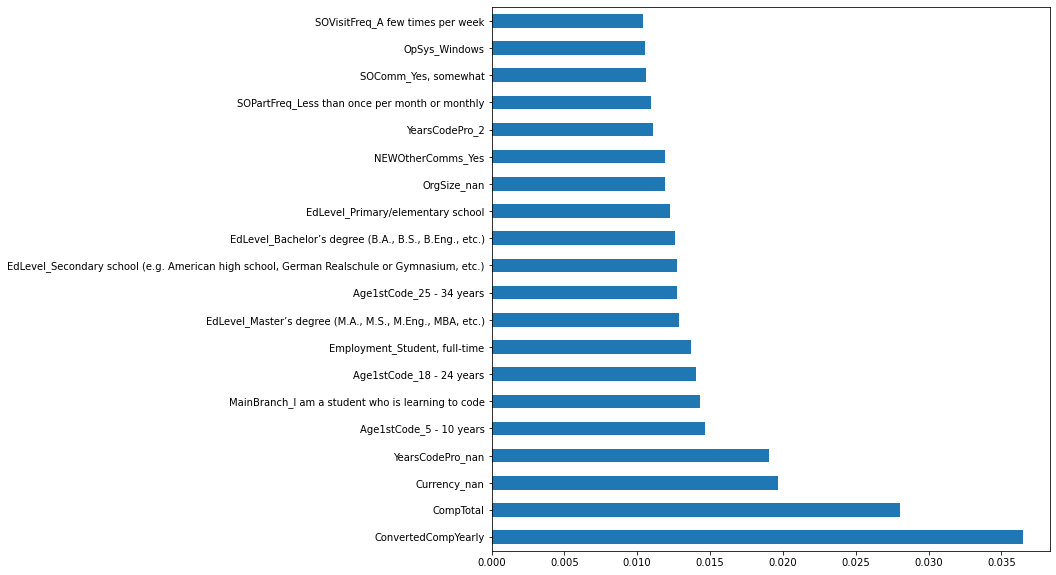

In [44]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

forest_importances.nlargest(20).plot(kind='barh', figsize=(10,0.25*40)); #len(forest_importances)


/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


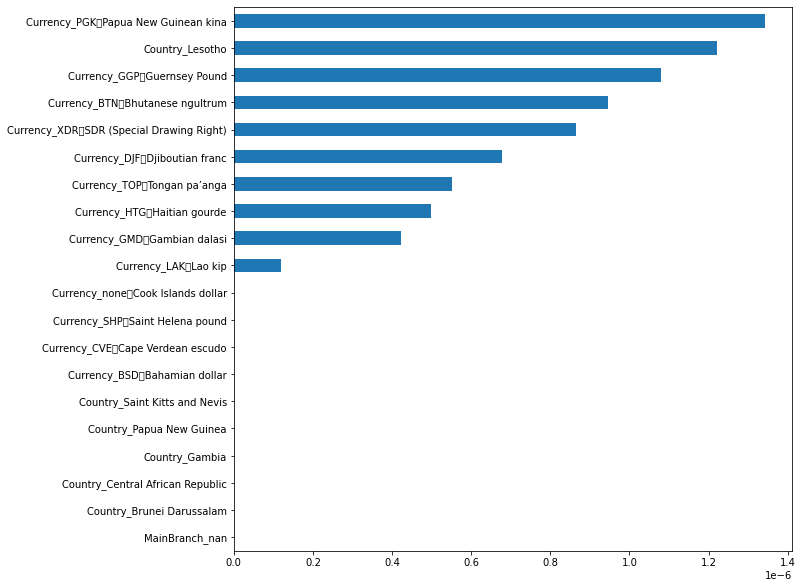

In [45]:
forest_importances.nsmallest(20).plot(kind='barh', figsize=(10,0.25*40)); #len(forest_importances)


In [46]:
fill_num_na['LearnCode'].head()

0    Coding Bootcamp;Other online resources (ex: vi...
1    Other online resources (ex: videos, blogs, etc...
2    Other online resources (ex: videos, blogs, etc...
3                                                  NaN
4                              Friend or family member
Name: LearnCode, dtype: object

In [47]:
fill_num_na['LearnCode'].str.get_dummies(sep=';')

,Books / Physical media,Coding Bootcamp,Colleague,Friend or family member,Online Courses or Certification,Online Forum,Other (please specify):,"Other online resources (ex: videos, blogs, etc)",School
0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
83434,0,0,0,0,0,1,0,1,1
83435,1,0,0,0,1,1,0,1,1
83436,0,0,0,0,0,0,0,0,1
83437,1,0,0,0,1,0,0,0,0


In [48]:
for col in dont_use:
    X = pd.concat([X, fill_num_na[col].str.get_dummies(sep=';')], axis=1)
X.shape

(82403, 909)

In [49]:
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


In [50]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train, y_train)

cv = cross_val_score(rf,X_train,y_train,cv=5)
print(f'{cv} => mean = {cv.mean()}')


[0.6960215  0.70130883 0.70717753 0.70700416 0.70700416] => mean = 0.7037032362980494


In [51]:
# Make predictions for the test set
y_pred_test = rf.predict(X_test)

In [52]:
# View accuracy score
accuracy_score(y_test, y_pred_test)


0.7052303709396869

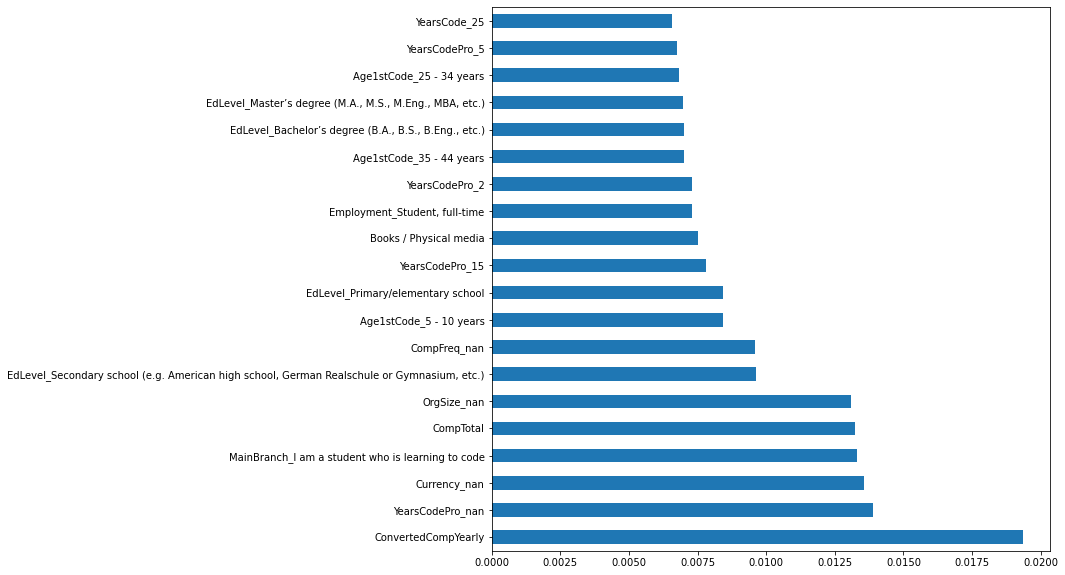

In [53]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

forest_importances.nlargest(20).plot(kind='barh', figsize=(10,0.25*40)); #len(forest_importances)
